# Assignment 2

Author: Tammie Koh

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define paths to your dataset directories
base_dir = 'dataset_animals'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'

In [3]:
# Initialize the ImageDataGenerator for the training set with normalization
train_datagen = ImageDataGenerator(rescale=1./255)

# Similarly, initialize the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
batch_size = 32

# Load images from the directories
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the target directory
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # Since we use categorical_crossentropy loss, we need categorical labels

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 6495 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.


In [5]:
# Step 2: Define the CNN architecture
model = models.Sequential([
    layers.InputLayer(shape=(150, 150, 3)),  # Adjust input shape as necessary, assuming images are resized to 150x150
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')
])

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


Epoch 1/10


/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2781 - loss: 1.5553

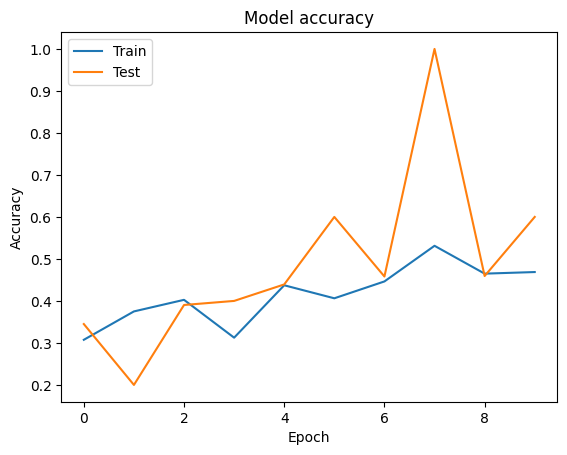

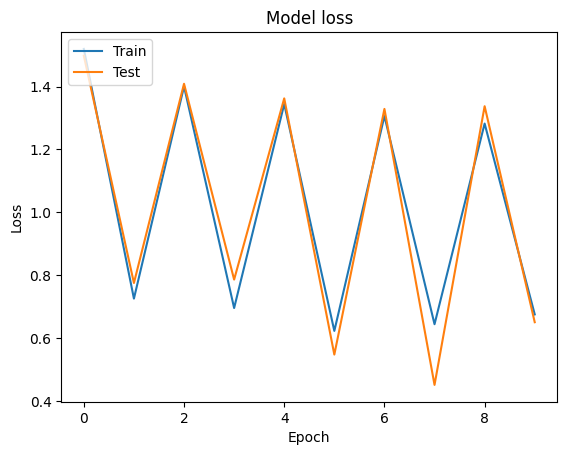

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Training Performance: The accuracy on the training set appears to fluctuate quite a bit from epoch to epoch. This might indicate that the model is not learning consistently, possibly due to a small dataset size, too high a learning rate, or other factors.

Generalization Gap: There is a noticeable difference between training and test accuracy, which suggests overfitting. Even though the training accuracy isn't very high, it's consistently above the test accuracy. The model is learning patterns specific to the training set that do not generalize well to the test set.

Loss Fluctuations: Similarly, the loss for both training and test data fluctuates significantly. Ideally, you'd like to see a smooth, downward trend in loss as training progresses, which would indicate that the model is learning effectively.

Test Accuracy: A test accuracy of approximately 46.34% indicates that the model performs relatively poorly on the test set. Given that there are 5 classes, this is not much better than random guessing, which would be 20% accuracy for a balanced dataset.

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4637 - loss: 1.3395
Test accuracy: 0.463443398475647


A test accuracy of approximately 46.34% indicates that the model performs relatively poorly on the test set. Given that there are 5 classes, this is not much better than random guessing, which would be 20% accuracy for a balanced dataset.

In [ ]:
train_classes = train_generator.classes
class_indices = train_generator.class_indices

# Count the number of occurrences of each class in the training set
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in train_classes:
    class_name = [class_name for class_name, index in class_indices.items() if index == class_index][0]
    class_counts[class_name] += 1

print(class_counts)


{'butterfly': 1539, 'cow': 1359, 'elephant': 1006, 'sheep': 1302, 'squirrel': 1289}


This is more or less a balanced dataset. We can look to ways to improve this performance by using transfer learning.

## 1. Data Augmentation

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the data generators
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6495 images belonging to 5 classes.


In [ ]:
def create_model(base_model):
    base_model.trainable = False  # Freeze the layers of the pre-trained model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)  # Assuming we have 5 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize pre-trained models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Create models
vgg16_model = create_model(vgg16_base)
resnet50_model = create_model(resnet50_base)
mobilenetv2_model = create_model(mobilenetv2_base)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/var/folders/j3/2xy_ffxd6jq618phh49pk1b00000gn/T/ipykernel_39427/4006250.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Without augmentation

In [ ]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

In [ ]:
history_vgg16_augmented = vgg16_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

#TODO: initialise the steps and validation steps

# steps_per_epoch = train_generator.samples // batch_size
# validation_steps = test_generator.samples // batch_size

# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10,
#     validation_data=test_generator,
#     validation_steps=validation_steps
# )

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.6110 - loss: 0.9714 - val_accuracy: 0.8001 - val_loss: 0.5519
Epoch 2/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 7:21 2s/step - accuracy: 0.6250 - loss: 0.8960

2024-03-18 17:08:47.741919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6250 - loss: 0.4502 - val_accuracy: 0.8000 - val_loss: 0.1854
Epoch 3/10


2024-03-18 17:08:48.087172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.7651 - loss: 0.6144 - val_accuracy: 0.8048 - val_loss: 0.5013
Epoch 4/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8125 - loss: 0.4824

2024-03-18 17:17:22.866027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.2424 - val_accuracy: 0.8000 - val_loss: 0.1943
Epoch 5/10


2024-03-18 17:17:23.212508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


138/202 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.7715 - loss: 0.5736

KeyboardInterrupt: 

In [ ]:
history_resnet50 = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

In [ ]:
history_resnet50_augmented = resnet50_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

In [ ]:
history_mobilenetv2 = mobilenetv2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

In [ ]:
history_mobilenetv2_augmented = mobilenetv2_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)